In [1]:
import cooler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyBigWig
import seaborn as sns
from matplotlib.colors import hex2color
from tqdm import tqdm
from wmb import cemba
from glob import glob 
import pathlib

In [2]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [3]:
ct = 'CA1-ProS_Glut'

In [4]:
rna_files = glob(f'/ceph/gale-1/qzeng/AmbData/Luisa/female_rna/Female_RNA_{ct}_*_merge.bw')
rna_df = pd.DataFrame({'rna':rna_files}, index = [pathlib.Path(path).name.split('_')[-2] for path in rna_files])

atac_files = glob(f'/ceph/gale-1/qzeng/AmbData/Luisa/female_atac/Female_{ct}_*_merge.bw')
atac_df = pd.DataFrame({'atac':atac_files}, index = [pathlib.Path(path).name.split('_')[-2] for path in atac_files])

mc_files = glob(f'/ceph/gale-1/qzeng/AmbData/CellType_Allc/F.CellType.Age/{ct}.*/{ct}.*.CGN-both.frac.bw')
mc_df = pd.DataFrame({'mcg':mc_files}, index = [pathlib.Path(path).name.split('.')[1] for path in mc_files])
mc_df = mc_df.loc[['8wk','9mo','18mo']]
mc_df.index = ['2mo','9mo','18mo']

mch_files = glob(f'/ceph/gale-1/qzeng/AmbData/CellType_Allc/M.CellType.Age/{ct}.*/{ct}.*.CHN-both.frac.bw')
mch_df = pd.DataFrame({'mch':mch_files}, index = [pathlib.Path(path).name.split('.')[1] for path in mch_files])
mch_df = mch_df.loc[['8wk','9mo','18mo']]
mch_df.index = ['2mo','9mo','18mo']

track_table = pd.concat([rna_df, atac_df, mc_df,mch_df], axis = 1)
track_table

,rna,atac,mcg,mch
9mo,/ceph/gale-1/qzeng/AmbData/Luisa/female_rna/Fe...,/ceph/gale-1/qzeng/AmbData/Luisa/female_atac/F...,/ceph/gale-1/qzeng/AmbData/CellType_Allc/F.Cel...,/ceph/gale-1/qzeng/AmbData/CellType_Allc/M.Cel...
18mo,/ceph/gale-1/qzeng/AmbData/Luisa/female_rna/Fe...,/ceph/gale-1/qzeng/AmbData/Luisa/female_atac/F...,/ceph/gale-1/qzeng/AmbData/CellType_Allc/F.Cel...,/ceph/gale-1/qzeng/AmbData/CellType_Allc/M.Cel...
2mo,/ceph/gale-1/qzeng/AmbData/Luisa/female_rna/Fe...,/ceph/gale-1/qzeng/AmbData/Luisa/female_atac/F...,/ceph/gale-1/qzeng/AmbData/CellType_Allc/F.Cel...,/ceph/gale-1/qzeng/AmbData/CellType_Allc/M.Cel...


In [5]:
from amb import *
age_palette = get_age_palette()
modality_palette = get_modality_palette()

modality_palette['rna'] = '#7D4195'
modality_palette['atac'] = '#EF7D1A'
modality_palette['mcg'] = '#36AE37'
modality_palette['mch'] = '#16499D'

In [6]:
#name = 'Il33'
bw_chrom = "chr13"
# slop = 3000
# gene_start = 29923114
# gene_end = 29962715

bw_start = 68162000
bw_end = 68186000
bw_bins = 600
rna_ylim = (0,18)
mcg_ylim = (0, 1)
mch_ylim = (0, 0.02)
atac_ylim = (0, 1000)

In [7]:

def _plot_bw(ax, data, fc, ylim):
    ax.fill_between(
        data["x"], y1=data["y"], fc=fc, linewidth=0, step="pre", rasterized=True
    )
    ax.set(xticks=[], ylim=ylim, yticks=[])


def plot_rna(ax, data, fc="tab:purple", ylim=rna_ylim):
    _plot_bw(ax, data, fc, ylim)
    return


def plot_mcg(ax, data, fc="tab:green", ylim=mcg_ylim):
    _plot_bw(ax, data, fc, ylim)
    return

def plot_mch(ax, data, fc="tab:blue", ylim=mch_ylim):
    _plot_bw(ax, data, fc, ylim)
    return

def plot_atac(ax, data, fc="tab:orange", ylim=atac_ylim):
    _plot_bw(ax, data, fc, ylim)
    return


def get_bw_data(
    track_path,
    bw_chrom=bw_chrom,
    bw_start=bw_start,
    bw_end=bw_end,
    _type="mean",
    bins=bw_bins,
    log = False
):
    with pyBigWig.open(track_path) as bw:
        bw_data = pd.Series(
            bw.stats(bw_chrom, bw_start, bw_end, type=_type, nBins=bins)
        )
        bw_data = bw_data.reset_index()
        bw_data.columns = ["x", "y"]
        if log == True:
            bw_data['y'] = np.log(bw_data['y'])
    return bw_data

plot_func = {"mcg": plot_mcg,"mch": plot_mch, "atac": plot_atac, "rna": plot_rna}


In [8]:
print(f"{bw_chrom}:{bw_start}-{bw_end}")

chr13:68162000-68186000


In [9]:
age_list = [ "2mo", "9mo","18mo"]
bw_track_types = ["rna", "mcg", "atac",'mch']

In [10]:
type_dict = {'mcg':'mean',
            'rna':'mean',
             'mch':'mean',
            'atac':'sum'}

log_dict = {'mcg':False,
            'mch':False,
            'rna':False,
            'atac':False}

In [11]:
#bed_path = '/home/qzeng/project/aging/230907-recall-dmr/Merge_DMR/mC_FILTER_DMR_BED/CA1-ProS_Glut.Hypo.aDMR.bed'

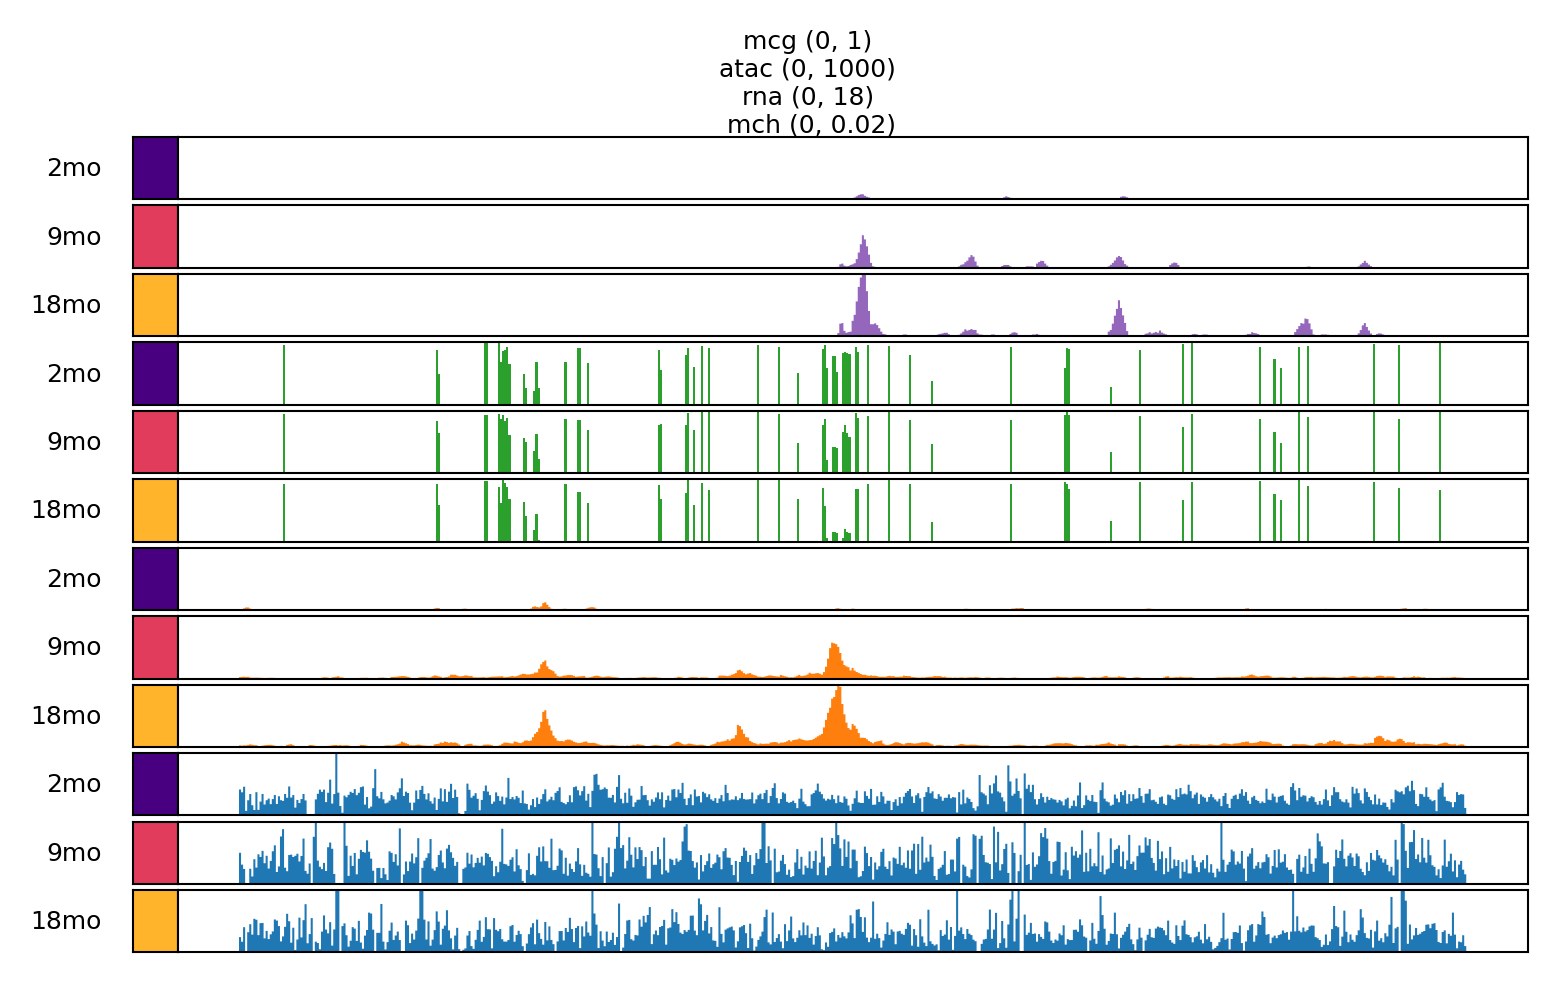

In [12]:
nrows = len(bw_track_types) * len(age_list)

fig = plt.figure(figsize=(6, 0.3 * nrows), dpi=300)

gs = fig.add_gridspec(nrows, 2, width_ratios=(0.3, 9), hspace=0.1, wspace=0)
ct_axes = [fig.add_subplot(gs[i, 0]) for i in range(nrows)]
track_axes = [fig.add_subplot(gs[i, 1]) for i in range(nrows)]

axes = track_axes
for i, track_type in enumerate(bw_track_types):
    ax_idx_start = i * len(age_list)
    _axes = axes[ax_idx_start : ax_idx_start + len(age_list)]
    for ax, age in zip(_axes, age_list):
        track_path = track_table.loc[age, track_type]   
        bw_data = get_bw_data(track_path, _type=type_dict[track_type], log = log_dict[track_type])
        plot_func[track_type](ax=ax, data=bw_data)
        for spine in ax.spines.values():
            spine.set(linewidth=0.5)

axes = ct_axes
use_annot = ['2mo', '9mo','18mo','2mo','9mo', '18mo','2mo', '9mo','18mo','2mo', '9mo','18mo']
for ax, age in zip(axes, use_annot):
    color = hex2color(age_palette[age])
    ax.imshow(np.array(color)[None, None, :], aspect="auto")
    ax.set(xticks=[], yticks=[])
    for spine in ax.spines.values():
        spine.set(linewidth=0.5)
    ax.set_ylabel(age, rotation=0, fontsize=6, ha="right", va="center")
fig.suptitle(f"mcg {mcg_ylim}\natac {atac_ylim}\nrna {rna_ylim}\n mch {mch_ylim}\n", fontsize=6)
fig.savefig(f'{ct}.LTR.{bw_chrom}_{bw_start}-{bw_end}.pdf', bbox_inches='tight')

In [14]:
print(f"{bw_chrom}:{bw_start}-{bw_end}")

chr13:68162000-68186000


In [13]:
# import pyGenomeTracks.tracks as tracks
# from pyGenomeTracks.tracks.genes import GeneTrack